# Convolutional Neural Network for Handwriting Detection

**Project:** Handwriting Detection System

**Class:** CPT_S 437 Machine Learning

**Team Members:** Molly Iverson, Caitlin Graves, Chandler Juego

## Introduction


Convolutional Neural Network (CNN) is a type of deep learning algorithm specifically designed for image recognition and processing, making it ideal for tasks like feature extraction and classification of handwritten characters using the [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data). This dataset contains 70,000 handwritten examples, divided into 60,000 training examples and 10,000 testing examples.

## Data Processing


Import dependencies


In [ ]:
from array import array
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import struct

Download the MNIST dataset

In [ ]:
# Download latest version of dataset
input_path = kagglehub.dataset_download('hojjatk/mnist-dataset')

print('Path to dataset files:', input_path)

training_images_filepath = input_path + '/train-images.idx3-ubyte'
training_labels_filepath = input_path + '/train-labels.idx1-ubyte'
test_images_filepath = input_path + '/t10k-images.idx3-ubyte'
test_labels_filepath = input_path + '/t10k-labels.idx1-ubyte'

Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


Process the dataset

* Resize and normalize the images to a standard 28x28 pixels
* Scale pixal values to be between 1 and 0

In [ ]:
class MnistLoader:
    def __init__(self, train_img_path, train_lbl_path, test_img_path, test_lbl_path):
        self.train_img_path = train_img_path
        self.train_lbl_path = train_lbl_path
        self.test_img_path = test_img_path
        self.test_lbl_path = test_lbl_path

    def load_images(self, img_path):
        with open(img_path, 'rb') as f:
            magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
            # this dataset uses a value called "magic" to represent the type and structure of data stored in each file
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", f.read())
            images = np.array(image_data, dtype=np.uint8).reshape(size, rows, cols)
        return images

    def load_labels(self, lbl_path):
        with open(lbl_path, 'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = np.array(array("B", f.read()), dtype=np.int8)
        return labels

    def load_data(self):
        x_train = self.load_images(self.train_img_path)
        y_train = self.load_labels(self.train_lbl_path)
        x_test = self.load_images(self.test_img_path)
        y_test = self.load_labels(self.test_lbl_path)
        return (x_train, y_train), (x_test, y_test)

    def preprocess_images(self, images, new_size=(28, 28)):
        processed_images = []
        for img in images:
            pil_img = Image.fromarray(img)
            resized_img = pil_img.resize(new_size)
            normalized_img = np.array(resized_img) / 255.0  # Normalize pixel values
            processed_images.append(normalized_img)
        return np.array(processed_images)

Show some letter images

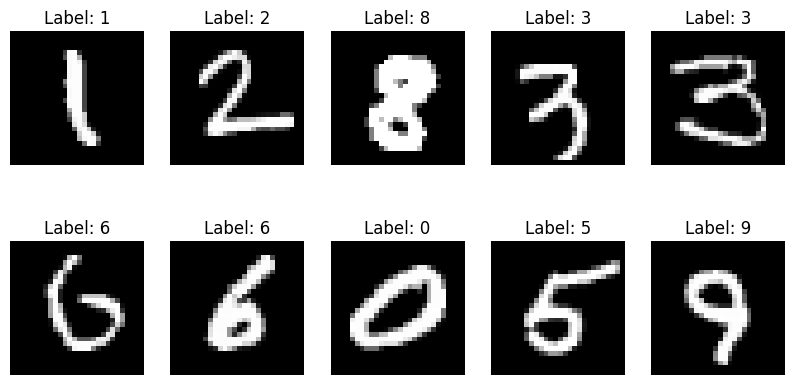

In [ ]:
# Initialize and load the data
mnist_loader = MnistLoader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

# Preprocess images (resize and normalize)
x_train_processed = mnist_loader.preprocess_images(x_train)
x_test_processed = mnist_loader.preprocess_images(x_test)

# Display some sample images with their labels
def display_samples(images, labels, num_samples=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

# Show random sample images from training data
display_samples(x_train_processed, y_train)

# CNN

## Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

# Add a channels dimension to the data for Conv2D to work
x_train_processed = x_train_processed[..., np.newaxis]
x_test_processed = x_test_processed[..., np.newaxis]

# Build the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(64, (3,3), input_shape=x_train_processed.shape[1:]))  # Shape is (28, 28, 1) for MNIST
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second convolutional layer
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening layer and dense layers
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# Output layer for 10 classes (digits 0-9) with softmax activation
model.add(Dense(10))
model.add(Activation('softmax'))

# Compile the model with a categorical cross-entropy loss
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Train with early stopping
history = model.fit(x_train_processed, y_train, batch_size=128, epochs=5, validation_data=(x_test_processed, y_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.7417 - loss: 0.7916 - val_accuracy: 0.9786 - val_loss: 0.0693
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 179ms/step - accuracy: 0.9529 - loss: 0.1626 - val_accuracy: 0.9846 - val_loss: 0.0457
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.9677 - loss: 0.1099 - val_accuracy: 0.9869 - val_loss: 0.0389
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.9746 - loss: 0.0884 - val_accuracy: 0.9865 - val_loss: 0.0391
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.9772 - loss: 0.0782 - val_accuracy: 0.9902 - val_loss: 0.0313


## Evaluation


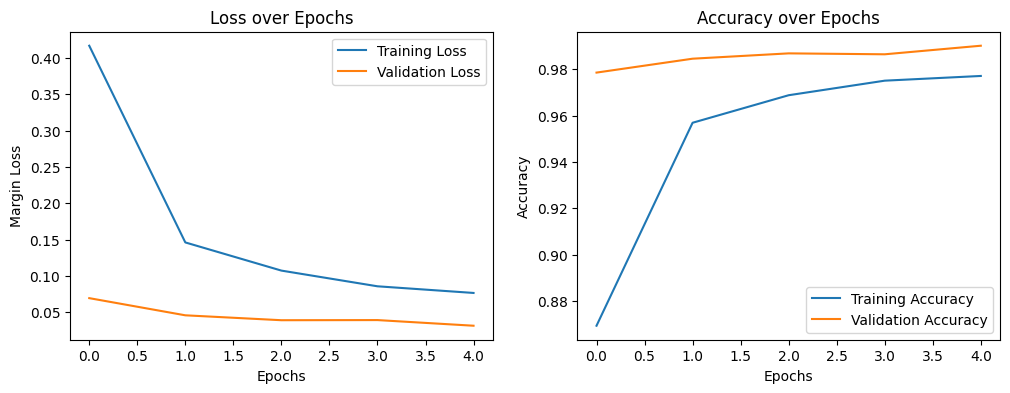

In [ ]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Margin Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()